# Imports

In [54]:
import time
import os
import sys
import pickle as pkl
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from IPython.display import clear_output, display
from ipywidgets import IntProgress

import vcf
from src.utils import progress_bar
from src.data import load_data

In [3]:
%load_ext autoreload
%autoreload 2

# Extract data from vcf files

## Get info

In [4]:

path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))

for record in vcf_reader:
    atts = [s for s in dir(record) if s[:2] != '__']
    break

In [5]:
print(atts)
print('='*60)

call = record.samples[0]
atts_call = [s for s in dir(call) if s[:2] != '__']

print(atts_call)
print('='*60)

hg_names = dict()
for i, c in enumerate(record.samples):
    assert c.sample not in hg_names.keys()
    hg_names[c.sample] = i

print('CALL:', call.gt_bases, call.gt_nums, call.phased, call.sample)
print('REC:', record.ID, record.REF, record.alleles, record.call_rate)

['ALT', 'CHROM', 'FILTER', 'FORMAT', 'ID', 'INFO', 'POS', 'QUAL', 'REF', '_compute_coordinates_for_indel', '_compute_coordinates_for_none_alt', '_compute_coordinates_for_snp', '_compute_coordinates_for_sv', '_sample_indexes', '_set_start_and_end', 'aaf', 'add_filter', 'add_format', 'add_info', 'affected_end', 'affected_start', 'alleles', 'call_rate', 'end', 'genotype', 'get_hets', 'get_hom_alts', 'get_hom_refs', 'get_unknowns', 'heterozygosity', 'is_deletion', 'is_indel', 'is_monomorphic', 'is_snp', 'is_sv', 'is_sv_precise', 'is_transition', 'nucl_diversity', 'num_called', 'num_het', 'num_hom_alt', 'num_hom_ref', 'num_unknown', 'samples', 'start', 'sv_end', 'var_subtype', 'var_type']
['called', 'data', 'gt_alleles', 'gt_bases', 'gt_nums', 'gt_phase_char', 'gt_type', 'is_het', 'is_variant', 'phased', 'ploidity', 'sample', 'site']
CALL: T|T 0|0 True HG00096
REC: rs149201999 T ['T', C] 1.0


## H[:, :16285]

### extract H[:, :16285]

In [71]:
record.samples, record.ID
col_names = []
path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))
n = len(hg_names)

H = np.zeros((2 * n, 0), dtype=np.int8)

for record_number, record in enumerate(vcf_reader):
    if (record.call_rate != 1.0) or (not record.is_snp) or (record.num_called != n):
        continue
     
    new_col = np.zeros((2*n, 1))
    for call in record.samples:
        h_row = 2 * hg_names[call.sample]
        assert call.phased
        
        new_col[h_row, 0] = int(call.gt_nums[0])
        new_col[h_row+1, 0] = int(call.gt_nums[-1])
    
    H = np.hstack([H, new_col])
    col_names.append(record.ID)
    
    if (record_number % 100) == 0:
        np.savetxt('data/H.txt', H)
        clear_output()
        print('r_num={0}; nc={1}'.format(record_number, H.shape[1]))
        
        f = open('data/variant_names.p', 'wb')
        pkl.dump(col_names, f)
        f.close()
        
    if H.shape[1] == 15000:
        np.savetxt('data/H.txt', H)
    
clear_output()
print('finished with %d columns' % H.shape[1])
       
    

r_num=17300; nc=16383


KeyboardInterrupt: 

In [6]:
col_names = []
path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))
n = len(hg_names)

Hs = 0
for record_number, record in enumerate(vcf_reader):
    if (record.call_rate != 1.0) or (not record.is_snp) or (record.num_called != n):
        continue
    
    col_names.append(record.ID)
    Hs += 1
    
    if Hs == 16285:
        break
    
f = open('data/variant_names.p', 'wb')
pkl.dump(col_names, f)
f.close()
        
    

### Clean H[:, :16285]

In [11]:
H = np.loadtxt('data/H.txt')

f = open('data/variant_names.p', 'rb')
var_names = pkl.load(f)
f.close()

old_len = H.shape[1]

IntProgress(value=0, max=16285)

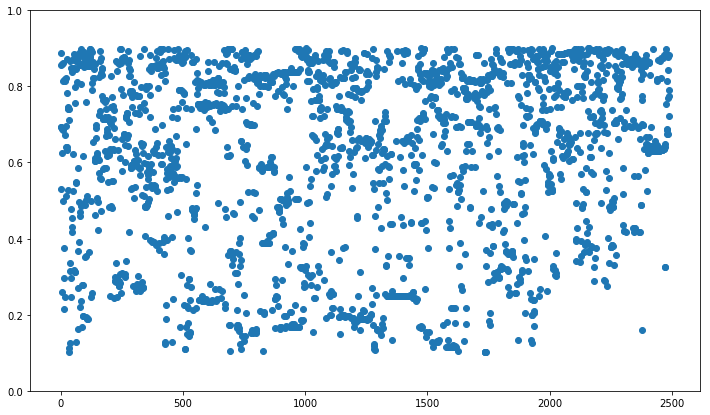

In [22]:
Hr = np.array(H)

p0s = []
clean_columns = []
clean_variant_names = []
for c, var_name in progress_bar(H.shape[1], enumerate(list(var_names))):
    p0 = len(np.argwhere(H[:, c] == 0)) / H.shape[0]
    if p0 > 0.9 or p0 < 0.1:
        continue
    else:
        p0s.append(p0)
        clean_columns.append(c)
        clean_variant_names.append(var_name)

f, ax = plt.subplots(figsize=(12, 7))
ax.scatter(range(len(p0s)), p0s)
ax.set_ylim([0, 1])
plt.show()

clean_columns = np.array(clean_columns)
np.savetxt('data/H1/clean/clean_columns.txt', clean_columns)

clean_variant_names = np.array(clean_columns)
np.savetxt('data/H1/clean/clean_variant_names.txt', clean_columns)

## H[:, 16285:53245]

In [35]:
col_names = []
path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))
n = len(hg_names)

H = np.zeros((2 * n, 0), dtype=np.int8)

for record_number, record in enumerate(vcf_reader):
    if (record.call_rate != 1.0) or (not record.is_snp) or (record.num_called != n):
        continue
    elif record_number < 16285:
        continue
     
    new_col = np.zeros((2*n, 1))
    for call in record.samples:
        h_row = 2 * hg_names[call.sample]
        assert call.phased
        
        new_col[h_row, 0] = int(call.gt_nums[0])
        new_col[h_row+1, 0] = int(call.gt_nums[-1])
       
    p0 = len(np.argwhere(new_col == 0)) / len(new_col)
    if (p0 < 0.1) or (p0 > 0.9):
        continue
    
    H = np.hstack([H, new_col])
    col_names.append(record.ID)
    
    if (record_number % 100) == 0:
        np.savetxt('data/H2/H.txt', H)
        clear_output()
        print('r_num={0}; nc={1}'.format(record_number, H.shape[1]))
        
        f = open('data/H2/variant_names.p', 'wb')
        pkl.dump(col_names, f)
        f.close()
        
    if H.shape[1] == 15000:
        np.savetxt('data/H2/H.txt', H)
    
clear_output()
print('finished with %d columns' % H.shape[1])



r_num=53000; nc=5106


KeyboardInterrupt: 

# Break into pop-specific arrays

In [87]:
# H = load_data()

pops = pd.read_csv('data/populations.csv').set_index('Sample')

row2hg = dict()
for (k, v) in hg_map.items():
    assert v not in row2hg.keys()
    row2hg[v] = k

pop25 = dict()
for eas in ['CHB', 'JPT', 'CHS', 'CDX', 'KHV']:
    pop25[eas] = 'EAS'
for eur in ['CEU', 'TSI', 'FIN', 'GBR', 'IBS']:
    pop25[eur] = 'EUR'
for afr in ['YRI', 'LWK', 'GWD', 'MXL', 'ESN', 'ASW', 'ACB']:
    pop25[afr] = 'AFR'
for amr in ['ASW', 'ACB', 'AMR', 'PUR', 'CLM', 'PEL']:
    pop25[amr] = 'AMR'
for sas in ['GIH', 'PJL', 'BEB', 'STU', 'ITU']:
    pop25[sas] = 'SAS'

n, m = H.shape

H_AFR = np.zeros((0, m))
H_AMR = np.zeros((0, m))
H_EAS = np.zeros((0, m))
H_EUR = np.zeros((0, m))
H_SAS = np.zeros((0, m))
pop2H = dict()
pop2H['AFR'] = H_AFR
pop2H['AMR'] = H_AMR
pop2H['EUR'] = H_EUR
pop2H['EAS'] = H_EAS
pop2H['SAS'] = H_SAS

for g_row in range(0, int(n/2)):
    hg = row2hg[g_row]
    h_row = g_row * 2  
    
    try:
        pop26 = pops.loc[hg]['Population']
    except KeyError:
        print(hg, hg in pops.index)
        continue
#     print(pop26)
    pop5 = pop25[pop26]
    
    newH = np.vstack([H[h_row], H[h_row+1]])
    
    pop2H[pop5] = np.vstack([pop2H[pop5], newH])
    
for name, H_ in pop2H.items():
    np.savetxt('data/H_%s.txt' % name, H_)

In [88]:
pops = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']
for p in pops:
    H_ = np.loadtxt('data/H_%s.txt' % p)
    print(p, H_.shape)


AFR (502, 7596)
AMR (352, 7596)
EAS (572, 7596)
EUR (758, 7596)
SAS (0,)


/home/cole/.virtualenvs/RL/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: loadtxt: Empty input file: "data/H_SAS.txt"
  This is separate from the ipykernel package so we can avoid doing imports until
